In [15]:
import numpy as np
import pandas as pd
import timeit
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#import cupy
import string
from sklearn import linear_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# import some text, in this case restuarant reviews

yelp_business_datapath = '/home/matt_valley/PycharmProjects/insight_2020a_project/Resto_names/yelp_dataset/review.json'

num_entries = 100
users = []
with open(yelp_business_datapath) as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= num_entries:
            break
df = pd.DataFrame(users)

In [2]:
# IMPORT ACTIVATED INSIGHTS DATA

survey_path_1 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2017 to mid 2018 comments.csv'
survey_path_2 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2018 to mid 2019 comments.csv'

df = pd.read_csv(survey_path_1, header=1)
#df2 = pd.read_csv(survey_path_2, header=1)

In [3]:
print(len(df))
df = df.dropna(how='any')
print(len(df))

88978
86080


In [4]:
df = df.rename(columns={"Comment": "text"})
df.head()

,Comment ID,Customer ID,Survey ID,Respondent ID,QID,text
0,3,1003,3,50882,61,"Kindness, honesty, appreciation"
1,5,1003,3,50884,61,"Everyone is friendly, compassionate and always..."
2,6,1003,3,50886,61,"let office staff PDO on their birthday, encour..."
3,8,1003,3,50888,61,They go above and beyond to do all the billing...
4,9,1003,3,50889,61,I am an independent contractor self employed s...


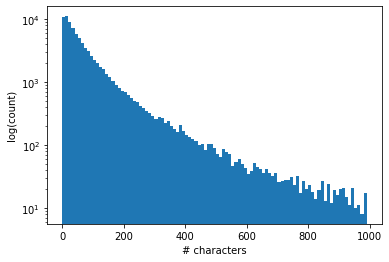

In [5]:
text_clean = [len(t) for t in df.text.values]

fig,ax = plt.subplots(1,1)
ax.hist(text_clean, np.arange(0,1000,10))
ax.set_yscale('log')
ax.set_ylabel('log(count)')
ax.set_xlabel('# characters')
plt.savefig('fig.png')

In [6]:
# load spacy model

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_vectors_web_lg' # many more words
nlp = spacy.load(model)
#sentencizer = nlp.create_pipe("sentencizer")
#nlp.add_pipe(sentencizer)

In [7]:
df = df[:5000]

In [8]:
# rudimentary text chunking pipeline

stopwords = list(STOP_WORDS)
punctuations = string.punctuation
parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens


all_sentences = []
all_sentence_entities = []
all_tokens = []
for r, review in enumerate(df.text):
    doc = nlp(review)
    #tokens = [token.text for token in doc]
    tokens = [spacy_tokenizer(s.text) for s in doc]
    sentences = [sent for sent in doc.sents]
    sentence_entities = [ent.text for ent in doc.ents]
    all_tokens.append(tokens)
    all_sentences.append(sentences)
    all_sentence_entities.append(sentence_entities)
    
df['tokens'] = all_tokens
df['sentences'] = all_sentences
df['entities'] = all_sentence_entities

In [109]:
'''
# do it another way, from https://gist.github.com/narulkargunjan/5319ed32d092d1fa7b52fec3a774e0e5
columns=['text',
           'log_probability',
           'stop?',
           'punctuation?',
           'whitespace?',
           'number?',
           'out of vocab.?']
token_df = pd.DataFrame(columns=columns)
    
for r, review in enumerate(df.text):
    doc = nlp(review)
    token_attributes = [(token.orth_,
                         token.prob,
                         token.is_stop,
                         token.is_punct,
                         token.is_space,
                         token.like_num,
                         token.is_oov)
                        for token in doc]
    temp_df = pd.DataFrame(token_attributes, columns=columns)
    token_df = token_df.append(temp_df)
'''


"\n# do it another way, from https://gist.github.com/narulkargunjan/5319ed32d092d1fa7b52fec3a774e0e5\ncolumns=['text',\n           'log_probability',\n           'stop?',\n           'punctuation?',\n           'whitespace?',\n           'number?',\n           'out of vocab.?']\ntoken_df = pd.DataFrame(columns=columns)\n    \nfor r, review in enumerate(df.text):\n    doc = nlp(review)\n    token_attributes = [(token.orth_,\n                         token.prob,\n                         token.is_stop,\n                         token.is_punct,\n                         token.is_space,\n                         token.like_num,\n                         token.is_oov)\n                        for token in doc]\n    temp_df = pd.DataFrame(token_attributes, columns=columns)\n    token_df = token_df.append(temp_df)\n"

In [24]:
# data must be a list of strings
data = [sent for sent in df.text]

n_samples = 2000
n_features = 1000
n_components = 12
n_top_words = 8

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time.time()
tf = tf_vectorizer.fit_transform(data)
tfidf = tfidf_vectorizer.fit_transform(data)
print("done in %0.3fs." % (time.time() - t0))



done in 0.158s.


In [25]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [26]:
#Do LDA

lda = LatentDirichletAllocation(n_components=n_components,random_state=0, verbose=1, max_iter=20)
lda.fit(tfidf)

tf_feature_names = tf_vectorizer.get_feature_names()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print(tf_feature_names)
print(tfidf_feature_names)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20
['10', '100', '12', '24', '24hr', '30', 'ability', 'able', 'absolutely', 'accessible', 'accomplish', 'achieve', 'acknowledge', 'acres', 'act', 'active', 'activities', 'actually', 'address', 'adequate', 'admin', 'administration', 'administrator', 'adults', 'advance', 'advancement', 'affordable', 'age', 'agencies', 'agency', 'aging', 'ago', 'aides', 'alacare', 'allow', 'allowed', 'allowing', 'allows', 'alot'

In [27]:
print_top_words(lda, tfidf_feature_names, n_top_words)

Topic #0: good benefits hours communication understanding respect helpful flexible
Topic #1: residents care coworkers love work staff best better
Topic #2: family atmosphere think oriented pay treat work live
Topic #3: people love work wonderful working great care job
Topic #4: work great place friendly team environment yes welcoming
Topic #5: na teamwork mission really care lives residents values
Topic #6: caring schedule flexibility flexible supportive helping help work
Topic #7: workers staff cares management employees great residents works
Topic #8: family like feel home just feels make work
Topic #9: nice people resident different special beautiful amazing clients
Topic #10: unique clean employees support training activities families care
Topic #11: company employee culture pto recognition organization christian villa



In [114]:
# SENTIMENT ANALYSIS

# see: From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015 
# http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences



# Load our dataset
df_yelp = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/yelp_labelled.txt')
df_imdb = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/imdb_labelled.txt')
df_amz = pd.read_table('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/sentiment_labelled_sentences/amazon_cells_labelled.txt')

frames = [df_yelp,df_imdb,df_amz]

for colname in frames:
    colname.columns = ["Message","Target"]
    
# Assign a Key to Make it Easier
keys = ['Yelp','IMDB','Amazon']
sentiment_df = pd.concat(frames,keys=keys)

print(sentiment_df.shape)
sentiment_df.head()

(2745, 2)


Message  Target
Yelp 0                                 Crust is not good.       0
     1          Not tasty and the texture was just nasty.       0
     2  Stopped by during the late May bank holiday of...       1
     3  The selection on the menu was great and so wer...       1
     4     Now I am getting angry and I want my damn pho.       0

In [115]:
sentiment_model = spacy.load(model)
stopwords = list(STOP_WORDS)
punctuations = string.punctuation
parser = English()

In [116]:
# from https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/Text%20Classification%20With%20Machine%20Learning,SpaCy,Sklearn(Sentiment%20Analysis)/Text%20Classification%20&%20Sentiment%20Analysis%20with%20SpaCy,Sklearn.ipynb

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens

tokens = [spacy_tokenizer(s[0].text) for s in df.sentences]
    

In [117]:
#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()


# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = LinearSVC()


# Features and Labels
X = sentiment_df['Message']
ylabels = sentiment_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [118]:
# Fit our data
pipe.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fab650d3e90>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7fab63024440>,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                

In [119]:
# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)

In [120]:
# Accuracy
print("Test accuracy: ",pipe.score(X_test,y_test))
print("Train accuracy: ",pipe.score(X_train,y_train))

Test accuracy:  0.8069216757741348
Train accuracy:  0.9895264116575592


In [4]:
# VECTORIZE SENTENCES AND SENT FRAGMENTS

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_core_web_lg' # many more words
nlp = spacy.load(model, disable=["parser"])
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

In [5]:
print(nlp.pipe_names)

['tagger', 'ner', 'sentencizer']


In [6]:
def split_sentences(doc, pos_filter=['NOUN', 'VERB']):
    # take input document and vectorize in context, and clean
    # for topic model return nouns and verbs
    # for sentiment return  adverbs    
    # return list of lists, corresponding to the filtered entities within each sentences
    sent_text = []
    all_tokens = []
    all_token_vectors = []
    for span in doc.sents:
        span_doc = span.as_doc(copy_user_data=True)
        sent_text.append(span_doc.text)
        tokens = [t for i,t in enumerate(span_doc) if t.pos_ in pos_filter]
        all_tokens.append(tokens)
        token_vectors = [t.vector for i,t in enumerate(span_doc) if t.pos_ in pos_filter]
        all_token_vectors.append(token_vectors)
    return sent_text, all_tokens, all_token_vectors

In [7]:
print(len(df.text))

100


In [8]:
sentence_df = pd.DataFrame(columns=['sentences','tokens','token_vectors'])
for r, review in enumerate(df.text):
    doc = nlp(review)
    sentences, tokens, token_vectors = split_sentences(doc) 
    entry_df = pd.DataFrame()
    entry_df['sentences'] = sentences
    entry_df['tokens'] = tokens
    entry_df['token_vectors'] = token_vectors
    sentence_df = pd.concat([sentence_df, entry_df], axis=0)

In [9]:
mat = np.array(list(itertools.chain.from_iterable(sentence_df.token_vectors)))
mat.shape


(4197, 96)

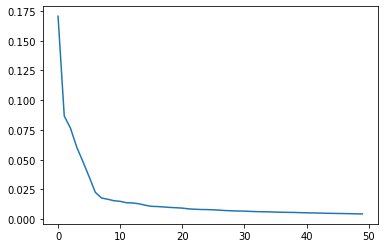

In [10]:
pca = PCA(n_components=50)
pca.fit(mat)
plt.plot(pca.explained_variance_ratio_)

In [128]:
mean_vecs = []
for s in token_vectors:
    vec = np.empty([96])
    for s_vec in s: # in each sentence
        vec = np.vstack((vec,s_vec))
        mvec = np.mean(vec, axis=0)
    mean_vecs.append(mvec)

mean_vecs = np.array(mean_vecs)
print(mean_vecs.shape)

(12, 96)


In [11]:
# cluster around seeds

seeds = [['food','taste','cooking'],
         ['service','attitude','helpful'],
         ['clean','decor','atmosphere']]

mean_seed_vectors = []
for k,seed in enumerate(seeds):
    seed_vectors = np.empty((0,96))
    for n,s in enumerate(seed):
        vec = nlp(s).vector
        vec = np.expand_dims(vec, axis=0)
        seed_vectors = np.vstack((seed_vectors,vec))
    mean_seed_vectors.append(np.mean(seed_vectors, axis=0))
    
mean_seed_vectors = np.array(mean_seed_vectors)
print(mean_seed_vectors.shape)


(3, 96)


In [14]:
#gmm = GaussianMixture(n_components=len(seeds), 
#                      covariance_type='full',
#                      means_init = mean_seed_vectors)

bic = []
for k in np.arange(2,20):
    gmm = GaussianMixture(n_components=k, 
                          covariance_type='full')
    mat_norm = normalize(mat, axis=1)
    y_idx = np.arange(0,mat.shape[0])
    X_train, X_test, y_train, y_test = train_test_split(mat_norm, 
                                                        y_idx, 
                                                        test_size=0.2, 
                                                        random_state=42)
    gmm.fit(X_train)
    #probs = gmm.predict_proba(X_test)
    bic.append(gmm.bic(X_test))

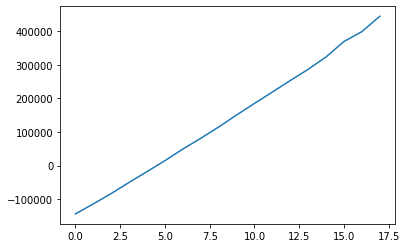

In [15]:
plt.plot(bic)

[tell, bar, things, years, ask, flavors, girls, concern, array, could]

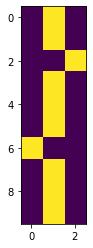

In [143]:
plt.imshow(probs[:10], vmin=0, vmax=1.0)

all_test_text = list(itertools.chain.from_iterable(sentence_df.tokens))
test_text = [t for i,t in enumerate(all_test_text) if i in list(y_test[:10])]
test_text

In [133]:
print(mean_probs.shape)
print(np.mean(mean_probs, axis=0))
print

(840, 3)
[0.         0.39871421 0.60128579]


<function print>

(array([1675.,    3.,    0.,    0.,    2.,    2.,    0.,    0.,    3.,
         835.]),
 array([3.63291872e-240, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <a list of 10 Patch objects>)

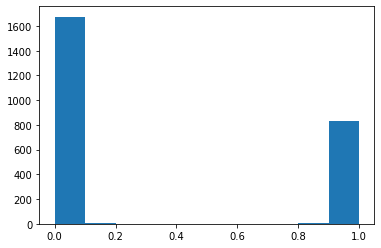

In [134]:
plt.hist(probs.flatten())

In [26]:
# search text for seeds

def find_words(col,word):
    # input column of text from dataframe
    # return row indices with matches to the word
    matches = [i for i,text in enumerate(col) if word in text]
    return matches


seeds = {'Residents':['resident','patient','senior'],
        'Communication':['listen','communicate','complaint'],
        'Management':['supervisor','boss','rule','management','administration'],
        'Scheduling':['schedule','busy'],
        'Compensation':['compensation','money','pay','benefit'],
        'Colleagues':['colleague','employee','peer','coworker','associate','teammate'],
        }

match_dict = dict((e,[]) for e in seeds)
for key,val in seeds.items():
    matches = []
    for v in val:
        word_idx = find_words(df.text, v)
        matches.append(word_idx)
    match_dict[key] = matches
    

In [27]:
total_count = 0
topic_freq = []
for key,val in match_dict.items():
    all_counts = list(itertools.chain.from_iterable(val))
    count = len(set(all_counts))
    total_count += count
    topic_freq.append(count/float(5000.0))
print(total_count)

1915


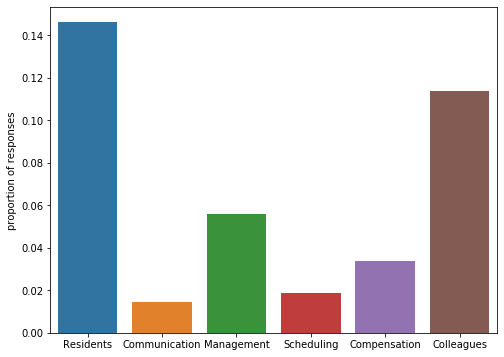

In [34]:
plot_dat = pd.DataFrame(columns=seeds.keys())
plot_dat.loc[0] = topic_freq

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(data=plot_dat, ax=ax)
ax.set_ylabel('proportion of responses')
plt.savefig('barplot.png')